# Starting point
## Maximum tidal amplitude compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [11]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

file_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','ocean_his_hourly.nc')
ds = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds.zeta.max('ocean_time')-ds.zeta.mean('ocean_time')

In [12]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_dataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

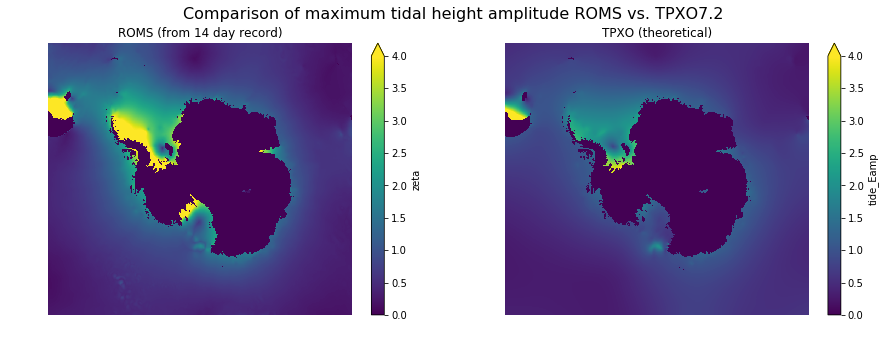

In [94]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5))
fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=4)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=4)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

... Roms gets about two times to high under the big ice shelves. Since the height looks ok everywhere else, this might be related to the kelvin waves. Two ideas to fix this:
1. no forcing on the continental shelf
2. increase bottom/ice shelf drag, high resolution might help

## Comparison of M2 and O1 amplitude maps
(others violate Rayleigh condition with just 14 day record) 
Apply t_tide tidal harmonic analysis on every grid point and fill O1 and M2 amplitude maps in Xarray dataset.
First define the function

In [133]:
import ttide as tt
import numpy as np
import pandas as pd

# add the 'src/visualization/' directory as one where we can import modules
vis_dir = os.path.join(os.pardir,'src','visualization')
sys.path.append(vis_dir)

# import my methods, make sure they get reloded by each call
from visualization.log_progress import log_progress
%aimport visualization.log_progress

def O1_M2_ampl(ds,xi_values,eta_values):
    ds['O1_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))
    ds['M2_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))

    #stime = datetime(1996,12,31,1)
    stime = pd.to_datetime(ds.ocean_time[0].values)

    for xi in log_progress(xi_values):
        #print('processing xi: ',xi)
        for eta in eta_values:

            ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)

            if ds_sl.zeta.isnull().values.any():
                ds.O1_ampl[eta,xi] = np.NaN
                ds.M2_ampl[eta,xi] = np.NaN
            else:
                signal = ds_sl.zeta.values
                latitude = ds_sl.lat_rho.values
                try:
                    ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                    ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                    ind_M2 = list(ttide_out['nameu']).index(b'M2  ')

                    O1_ampl = ttide_out['tidecon'][ind_O1][0]
                    M2_ampl = ttide_out['tidecon'][ind_M2][0]

                    ds.O1_ampl[eta,xi] = O1_ampl
                    ds.M2_ampl[eta,xi] = M2_ampl

                except TypeError:

                    ds.O1_ampl[eta,xi] = np.NaN
                    ds.M2_ampl[eta,xi] = np.NaN
                    
    return ds

then apply to dataset.

In [ ]:
ds = O1_M2_ampl(ds,ds.xi_rho.values,ds.eta_rho.values)

Plot against TPXO O1 and M2 amplitude maps

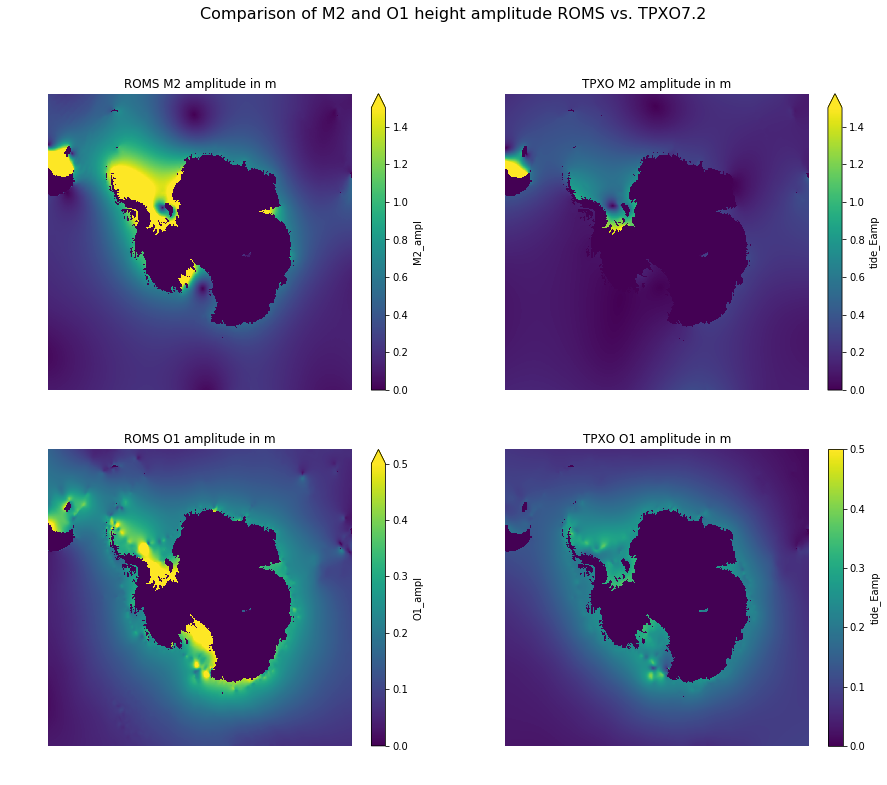

In [85]:
plt.close('all')
fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 height amplitude ROMS vs. TPXO7.2',fontsize=16)
ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
ax1.set_title('ROMS M2 amplitude in m')
ax1.axis('off')
dsf.tide_Eamp[0].plot(ax=ax2,vmax=1.5)
ax2.set_title('TPXO M2 amplitude in m')
ax2.axis('off')
ds.O1_ampl.fillna(0).plot(ax=ax3,vmax=0.5)
ax3.set_title('ROMS O1 amplitude in m')
ax3.axis('off')
dsf.tide_Eamp[5].plot(ax=ax4,vmax=0.5)
ax4.set_title('TPXO O1 amplitude in m')
ax4.axis('off')
plt.show()

... both are unacceptable to high.

# No forcing under the ice shelves
Dave suggested that the to high tides might come from some model amplification under the ice shelves. Therefore I look at an experiment, without tidal surface forcing where ice shelf is present.
## Generating the tidal mask

In [17]:
#mask tidal forcing
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)
#Pamp_masked = pott_ds.tide_Pamp.where((grid_ds.zice.values == 0.0 ,0.0))
#plt.close()
#Pamp_masked[2].plot()
#plt.show()

## Effect on max surface height anomaly

In [ ]:
out_path = os.path.join(pott_path,os.pardir,'waom10_ptds_masked.nc')
pott_ds['tide_Pamp']=Pamp_masked
pott_ds.to_netcdf(out_path,'w')

In [18]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_0006.nc')
ds_tm = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_tm_ampl_max = ds_tm.zeta[336:].max('ocean_time')-ds_tm.zeta[336:].mean('ocean_time')

In [110]:
# plot against tpxo as before
def plot_max_ampl(case_max_ampl_da,case_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    roms_ampl_max.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title('ROMS (from 14 day record)')
    ax1.axis('off')
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title('ROMS '+case_str+' (from 14 day record)')
    ax2.axis('off')
    tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO (theoretical)')
    ax3.axis('off')
    plt.show()

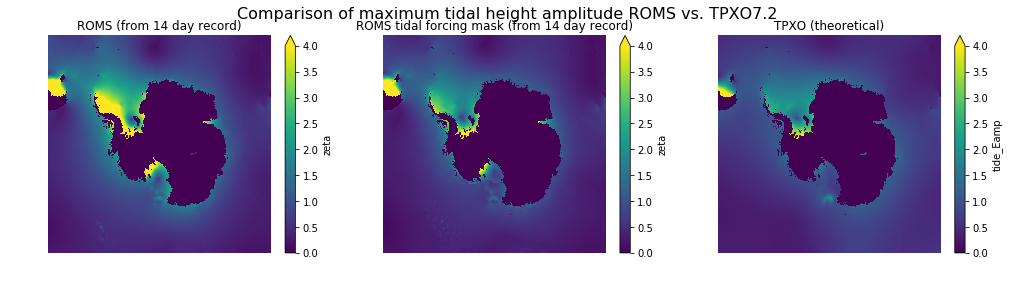

In [95]:
plot_max_ampl(roms_tm_ampl_max,'tidal forcing mask')

... this looks a lot better, though its still ssh amplitudes are still to high in the shallow areas under the ice shelves.
## M2 and O1 maps

In [ ]:
ds_tm = O1_M2_ampl(ds_tm,ds_tm.xi_rho.values,ds_tm.eta_rho.values)

In [96]:
def plot_M2O1(case_ds,case_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

    ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
    ax1.set_title('ROMS base case M2 amplitude in m')
    ax1.axis('off')

    case_ds.M2_ampl.fillna(0).plot(ax=ax2,vmax=1.5)
    ax2.set_title('ROMS '+ case_str +' M2 amplitude in m')
    ax2.axis('off')

    dsf.tide_Eamp[0].plot(ax=ax3,vmax=1.5)
    ax3.set_title('TPXO M2 amplitude in m')
    ax3.axis('off')


    ds.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
    ax4.set_title('ROMS base case O1 amplitude in m')
    ax4.axis('off')

    case_ds.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
    ax5.set_title('ROMS '+ case_str +' O1 amplitude in m')
    ax5.axis('off')

    dsf.tide_Eamp[5].plot(ax=ax6,vmax=0.5)
    ax6.set_title('TPXO O1 amplitude in m')
    ax6.axis('off')

    plt.show()

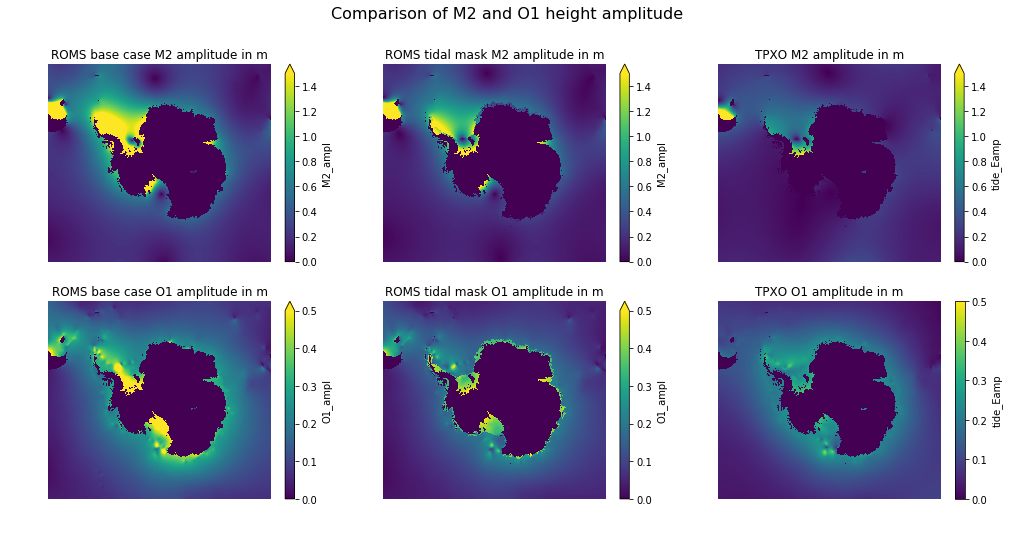

In [97]:
plot_M2O1(ds_tm,'tidal mask')

...

# 5x Drag coefficient
Ramping up the drag coefficent from 0.003 to 0.015 to represent conversion to internal tides, which is not present in 10 km model run.

In [71]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_5xCd_0006.nc')
ds_Cd = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_Cd_ampl_max = ds_Cd.zeta[336:].max('ocean_time')-ds_Cd.zeta[336:].mean('ocean_time')

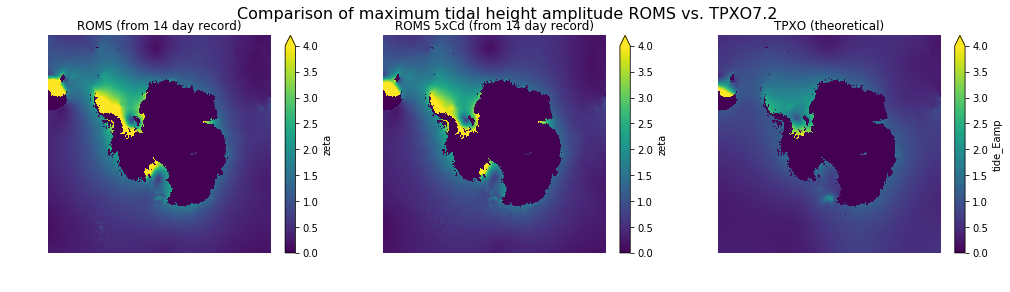

In [98]:
plot_max_ampl(roms_Cd_ampl_max,'5xCd')

... visible, but small decrease in max amplitude.
# 2x viscosity
Ramping up the visc2 from 500 m^2/s to 1000 m^2/s.

In [81]:
#look at results
import os
import xarray as xr
#file_path = os.path.join(os.pardir,'data','raw','waom10_tidal_mask','ocean_his_2xVisc2_0006.nc')
file_path = '/home/ubuntu/ocean_his_2xVisc2_0006.nc'
ds_Vi = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_Vi_ampl_max = ds_Vi.zeta[336:].max('ocean_time')-ds_Vi.zeta[336:].mean('ocean_time')

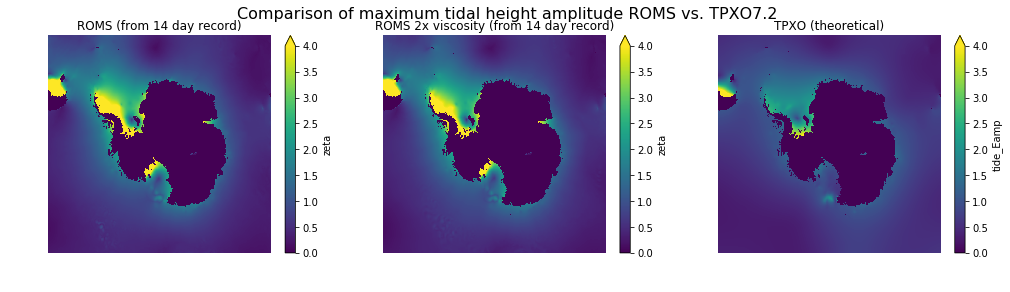

In [99]:
plot_max_ampl(roms_Vi_ampl_max,'2x viscosity')

... almost no impact.
# Mask shallow areas
Masking shallow areas (including all artificially deepened cells) by setting mask_rho == 0 where wct <= 50 m.

In [27]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
import os
import sys
# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from features.uvp_masks import uvp_masks
%autoreload uvp_masks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
grid_path = os.path.join(oos.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_mask.nc')
grd_ds = xr.open_dataset(grid_path)
rmask = grd_ds.mask_rho

In [20]:
mask_new = rmask.where(grd_ds.h + grd_ds.zice > 50,0)
rmask_val = mask_new.values
umask,vmask,pmask = uvp_masks(rmask)

In [21]:
import netCDF4 as nc
out_path = '/home/ubuntu/raijin/short/m68/oxr581/waom10_tidal_mask/Data/waom10/waom10_grd_mask.nc'
id = nc.Dataset(out_path,'a')
id.variables['mask_rho'][:,:]=rmask_val
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

In [87]:
#look at results
import os
import xarray as xr
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_ms_0006.nc')
ds_ms = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ms_ampl_max = ds_ms.zeta[336:].max('ocean_time')-ds_ms.zeta[336:].mean('ocean_time')

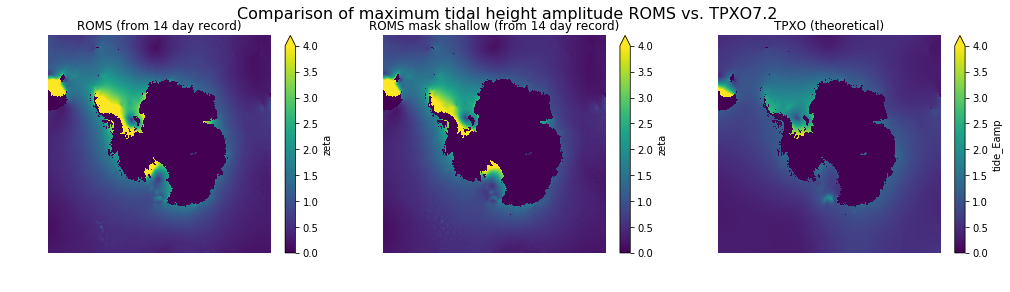

In [88]:
plot_max_ampl(roms_ms_ampl_max,'mask shallow')

... a bit better in the Weddell Sea and Amery. However in the Ross sea it seems just to shift the high amplitudes further in the direction of the kelvin wave propagation.
... more ideas would be trying a different vertical mixing scheme as recommended by Robin Robertson (MY and some GLS) and looking at the impact of increased resolution.

# 2x horizontal resolution
By increasing the horizontal resolution from 10km to 5km we hope to lose energy into baroclinic tides, which we don't resolve withthe coarse grid. Also better representation of bathymetry and ice draft, less smoothing and artificial deepening to only 30m water column thickness might have an impact. 

In [48]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5','ocean_his_0002.nc')
ds_hr = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_hr_ampl_max = ds_hr.zeta[:].max('ocean_time')-ds_hr.zeta[:].mean('ocean_time')

### Max tidal height amplitude

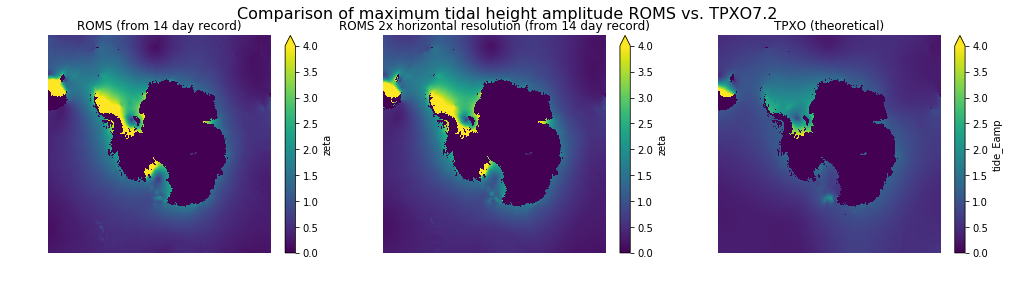

In [100]:
plot_max_ampl(roms_hr_ampl_max,'2x horizontal resolution')

### M2 O1 height amplitudes

In [ ]:
ds_hr = O1_M2_ampl(ds_hr,np.arange(298,1446),np.arange(278,1222))

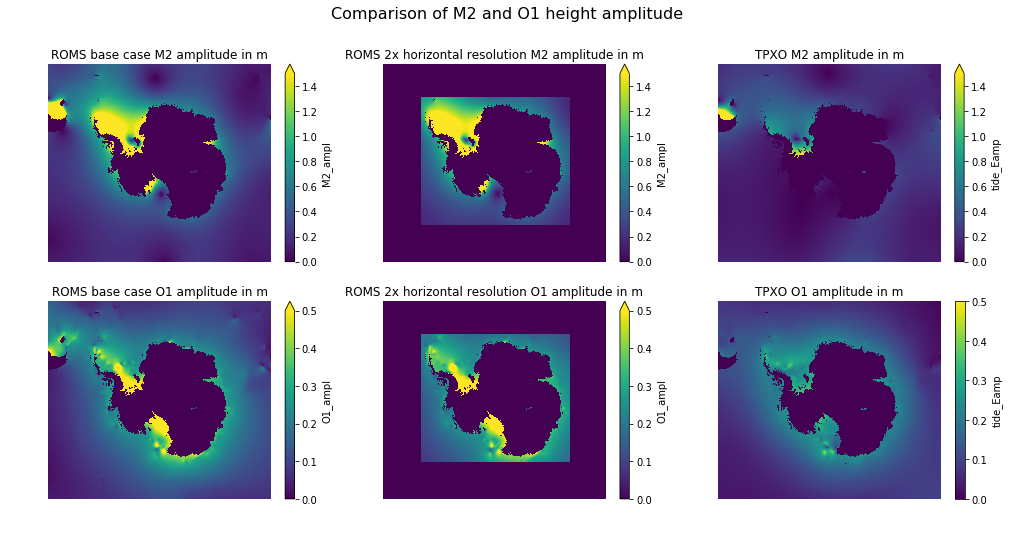

In [101]:
plot_M2O1(ds_hr,'2x horizontal resolution')

# 2x horizontal resolution and MY25 vertical mixing scheme
Following advice from Robin Roberston, I've changed the vertical mixing from LMD to MY. However, we expect MY to mix less than LMD and therefore possibly dissipate less energy?

In [104]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_MY','ocean_his_0002.nc')
ds_my = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_my_ampl_max = ds_my.zeta[:].max('ocean_time')-ds_my.zeta[:].mean('ocean_time')

### Max tidal height amplitude

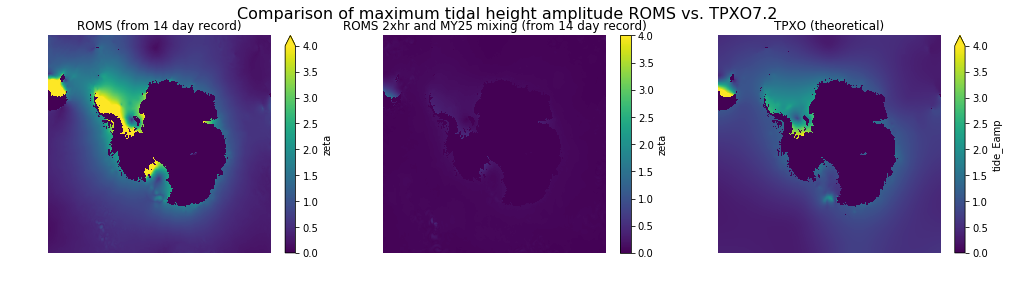

In [119]:
plot_max_ampl(roms_my_ampl_max,'2xhr and MY25 mixing')

### M2 O1 height amplitudes

In [ ]:
ds_my = O1_M2_ampl(ds_my,np.arange(298,1446),np.arange(278,1222))

In [ ]:
plot_M2O1(ds_my,'2x hr and MY25 mixing')

# 2x horizontal resolution and no topography smoothing
Following Robins papaers, I try a case, where I don't apply any smooting to the topographz (bed rock and ice draft) to enhance internal tide generation over rough topography.

In [102]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_rough','ocean_his_0002.nc')
ds_ns = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ns_ampl_max = ds_ns.zeta[:].max('ocean_time')-ds_ns.zeta[:].mean('ocean_time')

### Max tidal height amplitude

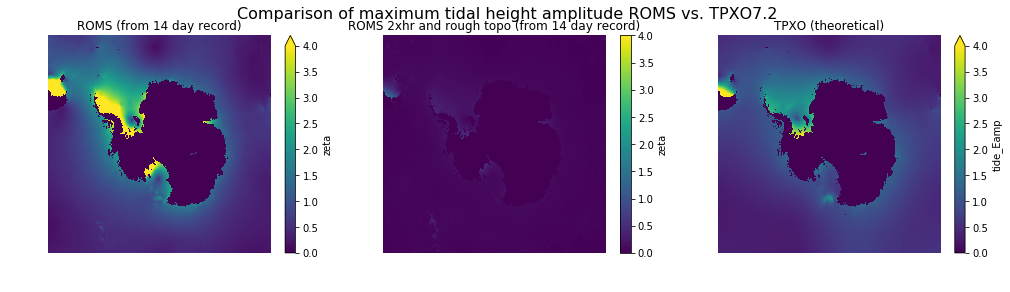

In [118]:
plot_max_ampl(roms_ns_ampl_max,'2xhr and rough topo')int or grided data time series

### M2 O1 height amplitudes

In [ ]:
ds_ns = O1_M2_ampl(ds_ns,np.arange(298,1446),np.arange(278,1222))

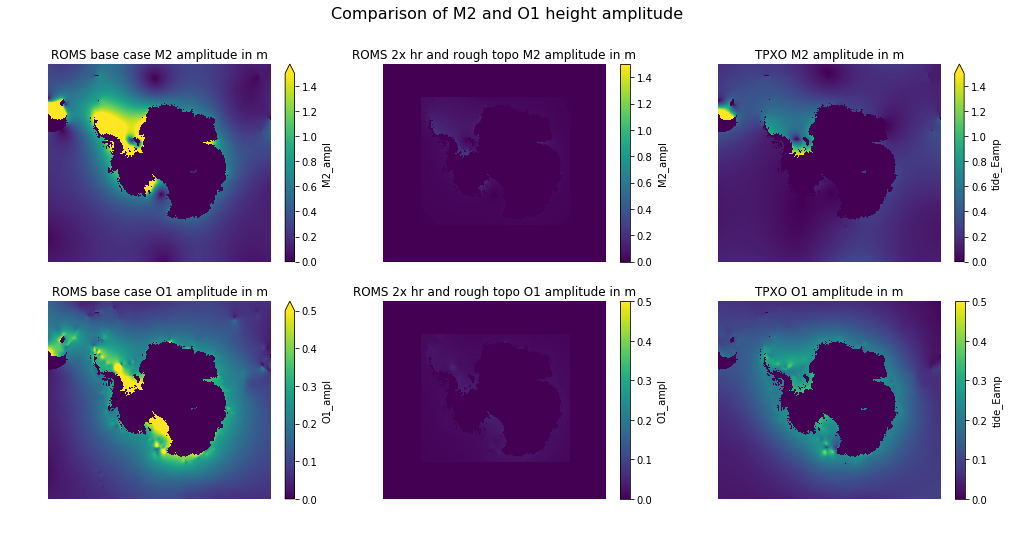

In [122]:
plot_M2O1(ds_ns,'2x hr and rough topoint or grided data time series')

## difference in maximum amplitude MY vs. no smoothing

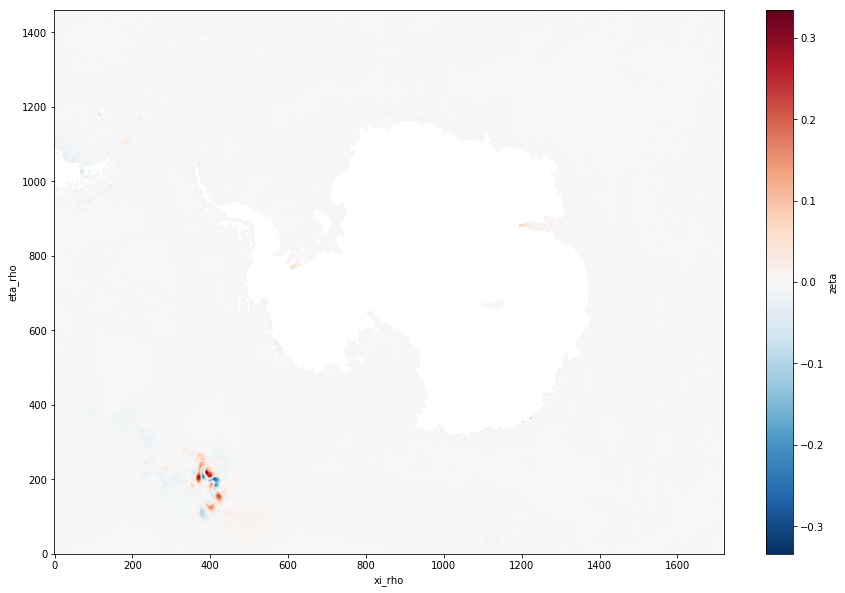

In [120]:
max_ampl_diff = roms_ns_ampl_max - roms_my_ampl_max
plt.close()
max_ampl_diff.plot(size=10)
plt.show()

... so there is a vivible difference between my and no smoothing, where the topo is changed!